## Reference :

- https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a
- https://www.youtube.com/watch?v=MnRskV3NY1k&t=1571s&ab_channel=T%C3%BCbingenMachineLearning
- https://www.dailydoseofds.com/formulating-and-implementing-the-t-sne-algorithm-from-scratch/

In [1]:
# import pandas as pd
# import matplotlib.pyplot as plt
# 
# df = pd.read_csv('fashion_mnist1.csv')
# X = df.iloc[:, 1:].values / 255.0
# y = df.iloc[:, 0].values
# print(f"{X.shape = }, {y.shape = }")
# 
# from sklearn.manifold import TSNE
# X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=True).fit_transform(X)
# fig, ax = plt.subplots()
# g1 = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="tab10")
# ax.axis("off")
# ax.set_title(f"Fashion MNIST, t-SNE plot with sample ")
# plt.colorbar(g1, ax=ax)
# plt.grid(True)
# plt.show()


# 2. (5 pts) Dimension Reduction Using t-SNE

## 2.1 (2 pts) Please build the t-SNE algorithm from scratch based on the equations below:

Please cite if you are referring to any source for the algorithms.
There are many hyperparameters to optimize, such as initialization (random seed), learning rate 𝜆 , momentum
𝛼(𝑡), iteration number, and perplexity.



$$

P_{j|i} = \frac{\exp\left(- \frac{\|x_i - x_j\|^2}{2\sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(- \frac{\|x_i - x_k\|^2}{2\sigma_i^2}\right)}

\\ 

\[
q_{j|i} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
\]

\\ 

\[
C = KL(P||Q) = \sum_i \sum_j P_{j|i} \log \frac{P_{j|i}}{q_{j|i}}
\]

\\

\[
\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + \|y_i - y_j\|^2)^{-1}
\]

\\

\[
y^{(t)} = y^{(t-1)} + \lambda \frac{\partial C}{\partial y} + \alpha(t)(y^{(t-1)} - y^{(t-2)})
\]

$$

In [2]:
import pandas as pd

df = pd.read_csv('fashion_mnist1.csv')
X = df.iloc[:, 1:].values / 255.0
y = df.iloc[:, 0].values
print(f"{X.shape = }, {y.shape = }")

X.shape = (10000, 784), y.shape = (10000,)


In [3]:
n_sample = 20


In [4]:
import os
import sys
import numpy as np
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(2024)
warnings.filterwarnings("ignore")


class TSNE:
    
    def __init__(self, perplexity=10, iterations=1000, n_components=2, learning_rate=100, momentum=0.5, initialization_method ='random', random_state=42):
        """
        t-SNE algorithm parameters
            :param perplexity: Perplexity
            :param iterations: number of Iterations the gradient descent algorithm will run
            :param n_components: Number of components
            :param learning_rate: Learning Rate
            :param momentum: momentum
            :param initialization_method: Initialization method for the t-SNE
            :param random_state: Random State
        """
        self.perplexity = perplexity
        self.iterations = iterations
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.initialization_method = initialization_method
        self.random_state = random_state
        
    def _params(self):
        parameters = {
            'perplexity': self.perplexity,
            'iters': self.iterations,
            'lrn_rate': self.learning_rate,
            'momentum': self.momentum,
            'init_method': self.initialization_method,
        }
        return ",".join(f"{k}={v}" for k, v in parameters.items())
            
    def _find_sigma(self, norm, i, perplexity):
        """
        Helper function to obtain σ's based on user-specified perplexity.
            :param norm: pairwise squared differences between data points
            :param i: Iteration number
            :param perplexity: desired Perplexity
        
        return: sigma that satisfies the perplexity condition.
        """
        result = np.inf  # Set first result to be infinity
        std_norm = np.std(norm)  # Use standard deviation of norms to define search space
        sigma = 0
        for sigma_i in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
            # Equation 1 Numerator
            p = np.exp(-(norm**2) / (2 * sigma_i**2))
            p[i] = 0
    
            p_new = np.maximum(p / np.sum(p), sys.float_info.min)
    
            # Shannon Entropy
            H = -np.sum(p_new * np.log2(p_new))
    
            # Get log(perplexity equation) as close to equality
            if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
                result = np.log(perplexity) - H * np.log(2)
                sigma = sigma_i
    
        return sigma
    
    def get_original_pairwise_affinities(self, X, perplexity):
        """
            :param X: input data
            :param perplexity: perplexity
    
        :return - original high dimension probability
        """
        path = f"p_ij_n_{X.shape[0]}_perplexity_{perplexity}.npy" 
        if os.path.exists(path):
            return np.load(path)
        n = X.shape[0]
        print("Starting the high dimension computation...")
        p_ij = np.zeros(shape=(n, n))
        for i in tqdm(range(0, n), desc="Computing"):
            diff = X[i] - X
            norm = np.linalg.norm(diff, axis=1)
            sigma_i = self._find_sigma(norm, i, perplexity)  
            p_ij[i, :] = np.exp(-(norm**2) / (2 * sigma_i**2))
            np.fill_diagonal(p_ij, 0)
            p_ij[i, :] = p_ij[i, :] / np.sum(p_ij[i, :])
    
        p_ij = np.maximum(p_ij, sys.float_info.min)
        print("Completed the high dimension computation...")
        np.save(path, p_ij)
        return p_ij

    # def binary_search(self, norm_squared: np.ndarray, i: int, perplexity: float, tol: float = 1e-5, max_iter: int = 50) -> float:
    #     """
    #     Helper function to obtain σ_i based on user-specified perplexity using binary search.
    # 
    #     Parameters:
    #         norm_squared (np.ndarray): Squared Euclidean distances between x_i and all x_j.
    #         i (int): Index of the current data point.
    #         perplexity (float): Desired perplexity.
    #         tol (float): Tolerance for the difference between computed and desired perplexity.
    #         max_iter (int): Maximum number of iterations.
    # 
    #     Returns:
    #         float: The value of σ_i that satisfies the perplexity condition.
    #     """
    #     # Initialize beta (inverse variance)
    #     beta_min = -np.inf
    #     beta_max = np.inf
    #     beta = 1.0  # Initial value of beta = 1 / (2σ_i^2)
    # 
    #     # Desired entropy is log2(perplexity)
    #     log_perplexity = np.log2(perplexity)
    # 
    #     for iteration in range(max_iter):
    #         # Compute the Gaussian kernel and entropy for the current beta
    #         P_i = np.exp(-norm_squared * beta)
    #         P_i[i] = 0  # Set P_{i|i} = 0
    # 
    #         sum_P_i = np.sum(P_i)
    #         if sum_P_i == 0:
    #             sum_P_i = np.finfo(np.float64).eps  # Avoid division by zero
    #         P_i /= sum_P_i
    # 
    #         # Compute the Shannon entropy H_i in bits (log base 2)
    #         H_i = -np.sum(P_i * np.log2(P_i + np.finfo(np.float64).eps))
    # 
    #         # Compute the difference between computed and desired entropy
    #         H_diff = H_i - log_perplexity
    # 
    #         # Check if the difference is within the tolerance level
    #         if np.abs(H_diff) < tol:
    #             break
    # 
    #         # Adjust beta based on the difference
    #         if H_diff > 0:
    #             beta_min = beta
    #             if beta_max == np.inf or beta_max == -np.inf:
    #                 beta *= 2.0
    #             else:
    #                 beta = (beta + beta_max) / 2.0
    #         else:
    #             beta_max = beta
    #             if beta_min == -np.inf:
    #                 beta /= 2.0
    #             else:
    #                 beta = (beta + beta_min) / 2.0
    # 
    #     # Compute σ_i from beta
    #     sigma_i = np.sqrt(1 / (2 * beta))
    #     return sigma_i
    # 
    # def get_original_pairwise_affinities_bs(self, X, perplexity):
    #     """
    #     Function to compute the pairwise affinities matrix P using binary search for σ_i.
    # 
    #     Parameters:
    #         X (np.ndarray): The input data array (n_samples x n_features).
    #         perplexity (int): The desired perplexity.
    # 
    #     Returns:
    #         np.ndarray: The symmetric pairwise affinities matrix P (n_samples x n_samples).
    #     """
    #     n = X.shape[0]
    #     P = np.zeros((n, n))
    # 
    #     print("Computing Pairwise Affinities using Binary Search...")
    # 
    #     for i in range(n):
    #         # Compute squared Euclidean distances between x_i and all other points
    #         diff_i = X[i] - X  # Shape: (n_samples, n_features)
    #         norm_squared = np.sum(diff_i ** 2, axis=1)  # Shape: (n_samples,)
    #         
    #         # Perform binary search to find σ_i
    #         sigma_i = self.binary_search(norm_squared, i, perplexity)
    # 
    #         # Compute the conditional probabilities P_{j|i}
    #         P_i = np.exp(-norm_squared / (2 * sigma_i ** 2))
    #         P_i[i] = 0  # Set P_{i|i} = 0
    # 
    #         sum_P_i = np.sum(P_i)
    #         if sum_P_i == 0:
    #             sum_P_i = np.finfo(np.float64).eps
    #         P_i /= sum_P_i
    # 
    #         P[i, :] = P_i
    # 
    #     # Symmetrize the matrix P and normalize
    #     P = (P + P.T) / (2 * n)
    #     P = np.maximum(P, np.finfo(np.float64).eps)  # Avoid numerical issues
    # 
    #     print("Completed Pairwise Affinities Matrix.\n")
    #     return P
    # 
    # def get_original_pairwise_affinities_bad(self, X, perplexity):
    #     """
    #     Compute the high-dimensional affinities (P) for t-SNE.
    # 
    #     Parameters:
    #         X (np.ndarray): Input data matrix of shape (n_samples, n_features).
    #         perplexity (float): Desired perplexity for the probability distribution.
    # 
    #     Returns:
    #         np.ndarray: The symmetric pairwise affinities matrix P of shape (n_samples, n_samples).
    #     """
    #     n = X.shape[0]
    #     print("Starting the high-dimensional computation...")
    # 
    #     # Compute the squared Euclidean distance matrix (n x n)
    #     sum_X = np.sum(np.square(X), axis=1)
    #     D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    # 
    #     # Initialize P matrix
    #     P = np.zeros((n, n))
    # 
    #     # Precompute beta (inverse variance) values for each point
    #     beta = np.ones(n)
    #     log_perplexity = np.log2(perplexity)
    # 
    #     # Function to compute P_i and entropy H_i for a given beta
    #     def Hbeta(Di, beta_i):
    #         P_i = np.exp(-Di * beta_i)
    #         P_i[Di == 0] = 0  # Set self-affinity to zero
    #         sum_P_i = np.sum(P_i)
    #         if sum_P_i == 0:
    #             sum_P_i = np.finfo(np.float64).eps
    #         H_i = np.log(sum_P_i) + beta_i * np.sum(Di * P_i) / sum_P_i
    #         P_i = P_i / sum_P_i
    #         return H_i, P_i
    # 
    #     # Perform binary search to find the correct beta for each point
    #     for i in tqdm(range(n), desc="Computing P-values"):
    #         betamin = -np.inf
    #         betamax = np.inf
    #         Di = D[i, :]
    #         Di[i] = 0  # Set self-distance to zero
    # 
    #         # Initialize beta_i
    #         beta_i = beta[i]
    # 
    #         # Compute initial entropy and P_i
    #         H_i, P_i = Hbeta(Di, beta_i)
    #         H_diff = H_i - log_perplexity
    #         max_iter = 50
    #         iter = 0
    # 
    #         # Binary search for beta_i
    #         while np.abs(H_diff) > 1e-5 and iter < max_iter:
    #             if H_diff > 0:
    #                 betamin = beta_i
    #                 if betamax == np.inf or betamax == -np.inf:
    #                     beta_i *= 2.0
    #                 else:
    #                     beta_i = (beta_i + betamax) / 2.0
    #             else:
    #                 betamax = beta_i
    #                 if betamin == -np.inf or betamin == np.inf:
    #                     beta_i /= 2.0
    #                 else:
    #                     beta_i = (beta_i + betamin) / 2.0
    # 
    #             # Recompute H_i and P_i with new beta_i
    #             H_i, P_i = Hbeta(Di, beta_i)
    #             H_diff = H_i - log_perplexity
    #             iter += 1
    # 
    #         # Set the final P_i in the P matrix
    #         P[i, :] = P_i
    # 
    #     # Symmetrize P and normalize
    #     P = (P + P.T) / (2 * n)
    #     P = np.maximum(P, sys.float_info.min)
    #     print("Completed the high-dimensional computation.")
    #     return P
    
    def get_symmetric_p_ij(self, p_ij):
        """
        Function to obtain symmetric affinities matrix utilized in t-SNE.
    
        Parameters:
        p_ij (np.ndarray): The input affinity matrix.
    
        Returns:
        np.ndarray: The symmetric affinities matrix.
    
        """
        # print("Computing Symmetric p_ij matrix....")
        # 
        # n = len(p_ij)
        # p_ij_symmetric = np.zeros(shape=(n, n))
        # for i in range(0, n):
        #     for j in range(0, n):
        #         p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * n)
        # 
        # # Set 0 values to minimum numpy value (ε approx. = 0)
        # ε = np.nextafter(0, 1)
        # p_ij_symmetric = np.maximum(p_ij_symmetric, ε)
        # 
        # print("Completed Symmetric p_ij Matrix. \n")
        # 
        # return p_ij_symmetric
        n = p_ij.shape[0]
        p_ij = (p_ij + p_ij.T) / (2 * n)
        p_ij = np.maximum(p_ij, sys.float_info.min)
        return p_ij
    
    def get_low_dimensional_affinities_v1(self, Y):
        """
        Obtain low-dimensional affinities.
            :param Y: input data
        
        return: low-dimensional affinities matrix.
        """
    
        n = len(Y)
        q_ij = np.zeros(shape=(n, n))
    
        for i in range(0, n):
            # Equation 4 Numerator
            diff = Y[i] - Y
            norm = np.linalg.norm(diff, axis=1)
            q_ij[i, :] = (1 + norm**2) ** (-1)
    
        # Set p = 0 when j = i
        np.fill_diagonal(q_ij, 0)
    
        # Equation 4
        q_ij = q_ij / q_ij.sum()
    
        # Set 0 values to minimum numpy value (ε approx. = 0)
        q_ij = np.maximum(q_ij, sys.float_info.min)
    
        return q_ij

    def get_low_dimensional_affinities(self, Y):
        n = Y.shape[0]
        sum_Y = np.sum(np.square(Y), axis=1)
        D = np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y)
        D = np.maximum(D, 0)
        num = (1 + D) ** (-1)
        np.fill_diagonal(num, 0)
        q_ij = num / np.sum(num)
        q_ij = np.maximum(q_ij, sys.float_info.min)
        return q_ij, num

    def _gradient_v1(self, p_ij, q_ij, Y):
        """
        Obtain gradient of cost function at current point Y.
        :param p_ij: The joint probability distribution matrix.
        :param q_ij: The Student's t-distribution matrix.
        :param Y   : The current point in the low-dimensional space.
    
        Returns:
        np.ndarray: The gradient of the cost function at the current point Y.
        """
    
        n = len(p_ij)
    
        # Compute gradient
        gradient = np.zeros(shape=(n, Y.shape[1]))
        for i in range(0, n):
            # Equation 5
            diff = Y[i] - Y
            A = np.array([(p_ij[i, :] - q_ij[i, :])])
            B = np.array([(1 + np.linalg.norm(diff, axis=1)) ** (-1)])
            C = diff
            gradient[i] = 4 * np.sum((A * B).T * C, axis=0)
    
        return gradient
    
    def _gradient(self, p_ij, q_ij, num, Y):
        """
        Obtain gradient of cost function at current point Y.
    
        Parameters:
        p_ij (np.ndarray): The joint probability distribution matrix.
        q_ij (np.ndarray): The Student's t-distribution matrix.
        num (np.ndarray): Numerator of q_ij, i.e., (1 + || y_i - y_j ||^2 )^{-1}
        Y (np.ndarray): The current point in the low-dimensional space.
    
        Returns:
        np.ndarray: The gradient of the cost function at the current point Y.
        """
        # Compute the difference matrix Z
        PQ_diff = p_ij - q_ij  # Shape: (n_samples, n_samples)
        Z = PQ_diff * num       # Element-wise multiplication
    
        # Compute the sum over rows (sum_j Z_ij)
        sum_Z = np.sum(Z, axis=1)  # Shape: (n_samples,)
    
        # Compute the gradient
        grad = 4 * (Y * sum_Z[:, np.newaxis] - Z @ Y)
    
        return grad
 
    def initialization(self, X, initialization_method) :
        """
        Initial t-SNE either randomly or using PCA.
            :param X: input data
            :param initialization_method: initialization method can be random or PCA
        
        :return - initial solution for t-SNE.
        """
        if initialization_method.upper() == "PCA":
            print("Initializing with PCA...")
            X_centered = X - X.mean(axis=0)
            U, S, V = np.linalg.svd(X_centered)
            return X_centered @ V.T[:, :self.n_components]
        else:
            print(f"Initialization method {initialization_method}, is not PCA, so random initialization is used.")
            return np.random.normal(loc=0, scale=1e-4, size=(X.shape[0], self.n_components))
        
    def fit(self, X):
        """
        train t-sne for the input data.
            :param X: Training data
        :return list of low-dimensional embeddings and the history of embeddings at each iteration.
        """
        n = X.shape[0]
    
        # Get original affinities matrix
        p_ij = self.get_original_pairwise_affinities(X, self.perplexity)
        p_ij = self.get_symmetric_p_ij(p_ij)
    
        # Initialization
        Y = np.zeros(shape=(self.iterations, n, self.n_components))
        Y[0] = np.zeros(shape=(n, self.n_components))
        Y[1] = np.array(self.initialization(X, self.initialization_method))
        costs, distances = [], []
    
        print("Optimizing Low Dimensional Embedding....")
        for t in tqdm(range(1, self.iterations - 1), desc="Iteration"):
                
            alpha, early_exaggeration = (0.5, 4) if t < 250 else (0.8, 1)
    
            # Get Low Dimensional Affinities
            # q_ij, num = self.get_low_dimensional_affinities(Y[t])
            # gradient = self._gradient(early_exaggeration * p_ij, q_ij, num, Y[t])
            
            q_ij = self.get_low_dimensional_affinities_v1(Y[t])
            gradient = self._gradient_v1(early_exaggeration * p_ij, q_ij, Y[t])
            
            Y[t + 1] = Y[t] - self.learning_rate * gradient + alpha * (Y[t] - Y[t - 1])  
    
            cost = np.sum(p_ij * np.log(p_ij / q_ij))
            costs.append(cost)    
            # Compute current value of cost function
            if t % 100 == 0 or t == 1:
                print(f"Iteration {t}: Value of Cost Function is {cost}")
    
        print(f"Completed Low Dimensional Embedding: Final Value of Cost Function is {costs[-1]}")
        embedding = Y[-1]
        return embedding, Y
    
    def plot_embeddings(self, embedding, y):
        fig, ax = plt.subplots()
        g1 = ax.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap="tab10")
        ax.axis("off")
        ax.set_title(f"Fashion MNIST, t-SNE plot with sample = {embedding.shape[0]} and parameters \n {self._params()}")
        plt.colorbar(g1, ax=ax)
        plt.grid(True)
        plt.show()
        

Initializing with PCA...
Optimizing Low Dimensional Embedding....


Iteration:   0%|          | 1/498 [00:00<02:13,  3.72it/s]

Iteration 1: Value of Cost Function is 2.1480821784741164


Iteration:  20%|██        | 100/498 [00:25<01:39,  4.01it/s]

Iteration 100: Value of Cost Function is 1.6159768311506584


Iteration:  40%|████      | 200/498 [00:50<01:14,  3.99it/s]

Iteration 200: Value of Cost Function is 1.6406588741617938


Iteration:  60%|██████    | 300/498 [01:15<00:49,  4.02it/s]

Iteration 300: Value of Cost Function is 1.1458140768025407


Iteration:  80%|████████  | 400/498 [01:40<00:24,  4.02it/s]

Iteration 400: Value of Cost Function is 1.0376174759240613


Iteration: 100%|██████████| 498/498 [02:05<00:00,  3.98it/s]

Completed Low Dimensional Embedding: Final Value of Cost Function is 1.0154959024274488


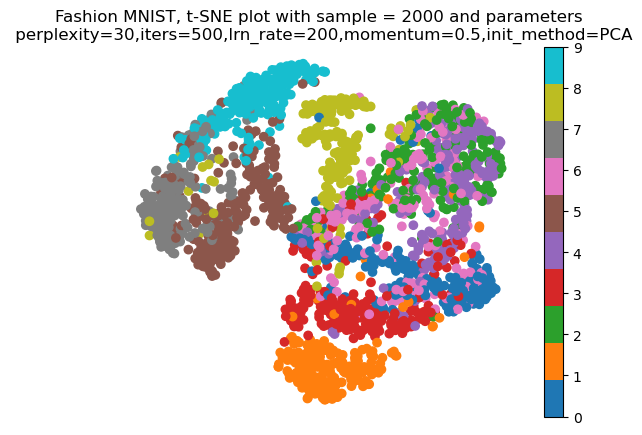

In [5]:
n_sample = 2000
# X = (X - X.mean(axis=0)) / X.std(axis=0)
X_sample = X[:n_sample:, ]
y_sample = y[:n_sample]
tsne = TSNE(perplexity=30, iterations=500, learning_rate=200, n_components=2, initialization_method='PCA')
solution, Y = tsne.fit(X_sample)
tsne.plot_embeddings(solution, y_sample)


# 2.2(1.5pts) Using the t-SNE method, please reduce the 784 dimensions to 2 dimensions. Please try at least 5 different hyperparameters conditions.

- For each hyperparameter condition, please calculate its corresponding D and J.
- Please calculate the sum of the distance D among the 10 centroids. 
- Each centroid corresponds to each label. Since there are 10 centroids, you should calculate distance for 45 pairs. 
- Also, please calculate the objective function J.
- Your goal is to maximize the distance D among the centroids and to minimize the objective function J by optimizing the hyperparameters.

$$

D = \sum_{i,j} \|y_i - y_j\|^2

\\

J = \sum_{i=1}^{k} \sum_{j=1}^{n} \|x_i - c_j\|^2

$$

In [6]:
def compute_centroids(embeddings, y):
    centroids = []
    for label in sorted(np.unique(y)):
        indices = np.where(y == label)[0]
        centroid = np.mean(embeddings[indices], axis=0)
        centroids.append(centroid)
    return np.array(centroids)


def compute_centroid_distance(centroids):
    D = 0.0
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            D += np.sum((centroids[i] - centroids[j]) ** 2)
    return D


def compute_objective_function(embedding, y, centroids):
    J = 0.0
    for idx, label in enumerate(sorted(np.unique(y))):
        indices = np.where(y == label)[0]
        J += np.sum(np.sum((embedding[indices] - centroids[idx]) ** 2, axis=1))
    return J

In [12]:
hyper_parameters = [
    {'perplexity': 10, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
    {'perplexity': 10, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
    {'perplexity': 30, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
    {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
    {'perplexity': 50, 'learning_rate': 200, 'iterations': 500,  'momentum': 0.5, 'initialization_method': 'random'},
    {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'},
]

results = []
n_sample = 2000
X_sample = X[:n_sample:, ]
y_sample = y[:n_sample]

for i, params in enumerate(hyper_parameters):
    print(f"Running Condition {i + 1}: {params}")
    
    tsne = TSNE(perplexity=params['perplexity'], iterations=params['iterations'], learning_rate=params['learning_rate'],)
    embeddings, Y = tsne.fit(X_sample)
    centroids = compute_centroids(embeddings, y_sample)
    D = compute_centroid_distance(centroids)
    J = compute_objective_function(embeddings, y_sample, centroids)
    results.append({'D': D, 'J': J, 'tsne': tsne, "centroids": centroids, "embeddings": embeddings, 
                    'params': tsne._params()})
    
    print(f"Condition {i + 1}: D = {D:.4f}, J = {J:.4f}")

Running Condition 1: {'perplexity': 10, 'learning_rate': 200, 'iterations': 500, 'momentum': 0.5, 'initialization_method': 'random'}
Starting the high dimension computation...


Computing: 100%|██████████| 2000/2000 [00:17<00:00, 114.47it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....


Iteration:   0%|          | 1/498 [00:00<02:07,  3.89it/s]

Iteration 1: Value of Cost Function is 5.028025058674959


Iteration:  20%|██        | 100/498 [00:25<01:40,  3.98it/s]

Iteration 100: Value of Cost Function is 2.332595982793404


Iteration:  40%|████      | 200/498 [00:50<01:14,  3.98it/s]

Iteration 200: Value of Cost Function is 2.0485381187182994


Iteration:  60%|██████    | 300/498 [01:28<01:18,  2.54it/s]

Iteration 300: Value of Cost Function is 1.459651260961489


Iteration:  80%|████████  | 400/498 [01:54<00:24,  3.99it/s]

Iteration 400: Value of Cost Function is 1.2553846778597155


Iteration: 100%|██████████| 498/498 [02:18<00:00,  3.60it/s]


Completed Low Dimensional Embedding: Final Value of Cost Function is 1.201552150888024
Condition 1: D = 260096.1317, J = 1950990.7885
Running Condition 2: {'perplexity': 10, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'}
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....


Iteration:   0%|          | 1/998 [00:00<04:07,  4.03it/s]

Iteration 1: Value of Cost Function is 5.028025058466572


Iteration:  10%|█         | 100/998 [00:24<03:43,  4.01it/s]

Iteration 100: Value of Cost Function is 2.427105521690778


Iteration:  20%|██        | 200/998 [00:49<03:20,  3.98it/s]

Iteration 200: Value of Cost Function is 2.2545702125676264


Iteration:  30%|███       | 300/998 [01:19<04:26,  2.62it/s]

Iteration 300: Value of Cost Function is 1.2946524401271307


Iteration:  40%|████      | 400/998 [01:54<02:29,  4.01it/s]

Iteration 400: Value of Cost Function is 1.1959092833249045


Iteration:  50%|█████     | 500/998 [02:33<03:58,  2.09it/s]

Iteration 500: Value of Cost Function is 1.176017626105517


Iteration:  60%|██████    | 600/998 [03:22<03:23,  1.96it/s]

Iteration 600: Value of Cost Function is 1.1659608582773509


Iteration:  70%|███████   | 700/998 [04:06<01:15,  3.95it/s]

Iteration 700: Value of Cost Function is 1.1607233559627008


Iteration:  80%|████████  | 800/998 [04:31<00:49,  4.02it/s]

Iteration 800: Value of Cost Function is 1.1571283796734448


Iteration:  90%|█████████ | 900/998 [04:57<00:24,  4.00it/s]

Iteration 900: Value of Cost Function is 1.154673574376918


Iteration: 100%|██████████| 998/998 [05:21<00:00,  3.10it/s]


Completed Low Dimensional Embedding: Final Value of Cost Function is 1.1529005340882013
Condition 2: D = 5473837.5251, J = 36315969.3466
Running Condition 3: {'perplexity': 30, 'learning_rate': 200, 'iterations': 500, 'momentum': 0.5, 'initialization_method': 'random'}
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....


Iteration:   0%|          | 1/498 [00:00<02:02,  4.05it/s]

Iteration 1: Value of Cost Function is 3.981241191862573


Iteration:  20%|██        | 100/498 [00:25<01:40,  3.97it/s]

Iteration 100: Value of Cost Function is 1.8066169592898187


Iteration:  40%|████      | 200/498 [00:50<01:16,  3.89it/s]

Iteration 200: Value of Cost Function is 1.6808166340927801


Iteration:  60%|██████    | 300/498 [01:15<00:49,  3.99it/s]

Iteration 300: Value of Cost Function is 1.12731545943467


Iteration:  80%|████████  | 400/498 [01:40<00:24,  4.04it/s]

Iteration 400: Value of Cost Function is 1.0215454025830446


Iteration: 100%|██████████| 498/498 [02:05<00:00,  3.98it/s]


Completed Low Dimensional Embedding: Final Value of Cost Function is 1.0018525894196628
Condition 3: D = 169757.8829, J = 928598.2070
Running Condition 4: {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'}
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....


Iteration:   0%|          | 1/998 [00:00<04:07,  4.02it/s]

Iteration 1: Value of Cost Function is 3.98124119292552


Iteration:  10%|█         | 100/998 [00:25<03:45,  3.98it/s]

Iteration 100: Value of Cost Function is 1.8341951322642942


Iteration:  20%|██        | 200/998 [00:51<03:20,  3.98it/s]

Iteration 200: Value of Cost Function is 1.757550451444378


Iteration:  30%|███       | 300/998 [01:16<02:52,  4.04it/s]

Iteration 300: Value of Cost Function is 1.04641730012783


Iteration:  40%|████      | 400/998 [01:41<02:28,  4.03it/s]

Iteration 400: Value of Cost Function is 1.0023767184724723


Iteration:  50%|█████     | 500/998 [02:06<02:03,  4.04it/s]

Iteration 500: Value of Cost Function is 0.9950475659801464


Iteration:  60%|██████    | 600/998 [02:31<01:38,  4.02it/s]

Iteration 600: Value of Cost Function is 0.9915878419212716


Iteration:  70%|███████   | 700/998 [02:56<01:15,  3.95it/s]

Iteration 700: Value of Cost Function is 0.9891105732758868


Iteration:  80%|████████  | 800/998 [03:21<00:49,  4.03it/s]

Iteration 800: Value of Cost Function is 0.9873287360406159


Iteration:  90%|█████████ | 900/998 [03:46<00:24,  4.04it/s]

Iteration 900: Value of Cost Function is 0.9859432967490382


Iteration: 100%|██████████| 998/998 [04:10<00:00,  3.98it/s]


Completed Low Dimensional Embedding: Final Value of Cost Function is 0.9848896141484894
Condition 4: D = 2925921.1553, J = 14912818.5711
Running Condition 5: {'perplexity': 50, 'learning_rate': 200, 'iterations': 500, 'momentum': 0.5, 'initialization_method': 'random'}
Starting the high dimension computation...


Computing: 100%|██████████| 2000/2000 [00:17<00:00, 116.39it/s]


Completed the high dimension computation...
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....


Iteration:   0%|          | 1/498 [00:00<02:03,  4.03it/s]

Iteration 1: Value of Cost Function is 3.4943636585468028


Iteration:  20%|██        | 100/498 [00:24<01:39,  4.02it/s]

Iteration 100: Value of Cost Function is 1.598701614147341


Iteration:  40%|████      | 200/498 [00:50<01:14,  4.03it/s]

Iteration 200: Value of Cost Function is 1.5299146083002149


Iteration:  60%|██████    | 300/498 [01:15<00:49,  3.99it/s]

Iteration 300: Value of Cost Function is 0.9608288526548341


Iteration:  80%|████████  | 400/498 [01:40<00:25,  3.89it/s]

Iteration 400: Value of Cost Function is 0.8944556522620585


Iteration: 100%|██████████| 498/498 [02:06<00:00,  3.95it/s]


Completed Low Dimensional Embedding: Final Value of Cost Function is 0.889313725398282
Condition 5: D = 123490.6855, J = 645802.0639
Running Condition 6: {'perplexity': 30, 'learning_rate': 500, 'iterations': 1000, 'momentum': 0.8, 'initialization_method': 'PCA'}
Initialization method random, is not PCA, so random initialization is used.
Optimizing Low Dimensional Embedding....


Iteration:   0%|          | 1/998 [00:00<05:09,  3.22it/s]

Iteration 1: Value of Cost Function is 3.981241191867076


Iteration:  10%|█         | 100/998 [00:27<05:13,  2.86it/s]

Iteration 100: Value of Cost Function is 1.8037782593798262


Iteration:  20%|██        | 200/998 [00:53<03:16,  4.05it/s]

Iteration 200: Value of Cost Function is 1.776013559845631


Iteration:  30%|███       | 300/998 [01:18<02:51,  4.07it/s]

Iteration 300: Value of Cost Function is 1.0434158289871962


Iteration:  40%|████      | 400/998 [01:43<02:26,  4.08it/s]

Iteration 400: Value of Cost Function is 0.9991355310590406


Iteration:  50%|█████     | 500/998 [02:07<02:02,  4.07it/s]

Iteration 500: Value of Cost Function is 0.9939270001804005


Iteration:  60%|██████    | 600/998 [02:32<01:37,  4.07it/s]

Iteration 600: Value of Cost Function is 0.9914603208203348


Iteration:  70%|███████   | 700/998 [02:57<01:14,  4.01it/s]

Iteration 700: Value of Cost Function is 0.9896265696327272


Iteration:  80%|████████  | 800/998 [03:22<00:50,  3.95it/s]

Iteration 800: Value of Cost Function is 0.9883283330261161


Iteration:  90%|█████████ | 900/998 [03:48<00:26,  3.71it/s]

Iteration 900: Value of Cost Function is 0.9872426706962704


Iteration: 100%|██████████| 998/998 [04:13<00:00,  3.94it/s]

Completed Low Dimensional Embedding: Final Value of Cost Function is 0.9862644319614893
Condition 6: D = 2938988.3187, J = 14909715.3046


In [13]:
results_df = pd.DataFrame.from_dict(results)
results_df[["params", "D", "J"]].head(10)


,params,D,J
0,"perplexity=10,iters=500,lrn_rate=200,momentum=...",2.600961e+05,1.950991e+06
1,"perplexity=10,iters=1000,lrn_rate=500,momentum...",5.473838e+06,3.631597e+07
2,"perplexity=30,iters=500,lrn_rate=200,momentum=...",1.697579e+05,9.285982e+05
3,"perplexity=30,iters=1000,lrn_rate=500,momentum...",2.925921e+06,1.491282e+07
4,"perplexity=50,iters=500,lrn_rate=200,momentum=...",1.234907e+05,6.458021e+05
5,"perplexity=30,iters=1000,lrn_rate=500,momentum...",2.938988e+06,1.490972e+07


# 2.3(1.5pts)

- Please draw 2D plot for the 5 hyperparameter conditions.
- Please legend different colors for the 10 labels in the graph.

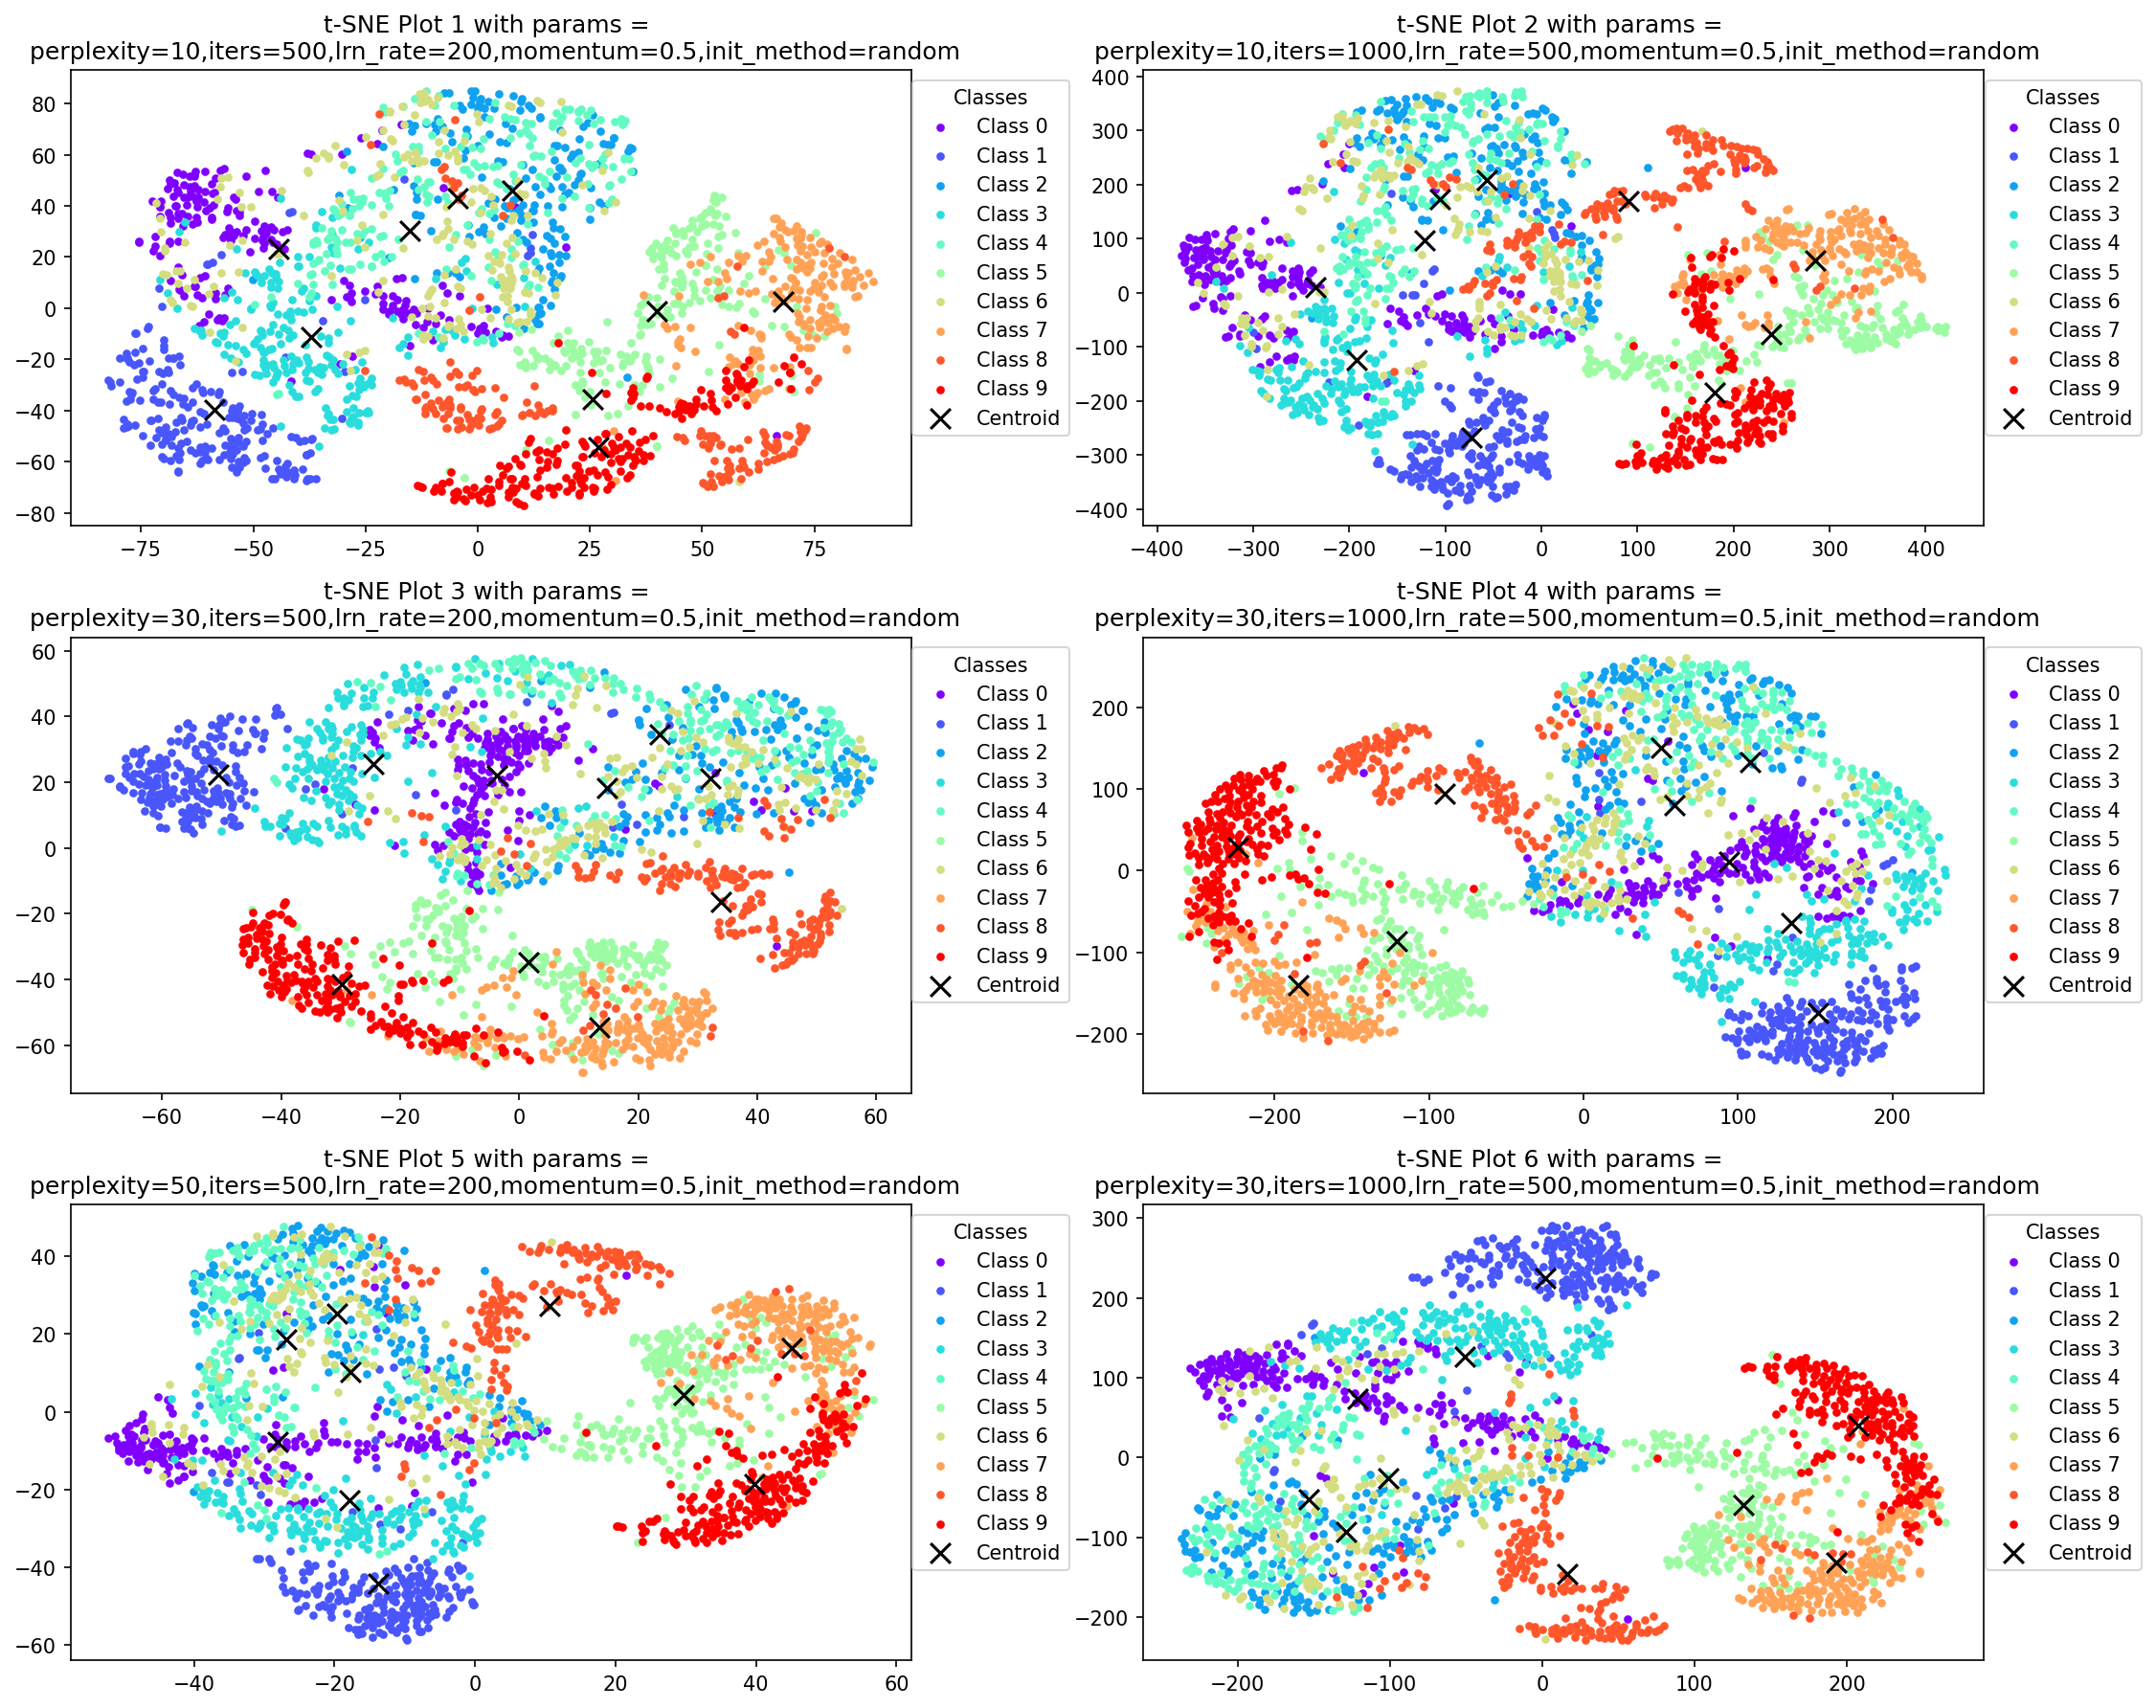

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12), dpi=150)
axes = axes.ravel()
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(y_sample))))  # Generate colors

# Iterate over each dictionary and each subplot
for i, data in enumerate(results):
    ax = axes[i]
    
    # Extract embeddings, labels, and centroids from the data
    embeddings = data['embeddings']
    labels = y_sample
    centroids = data['centroids']
    
    # Plot the t-SNE points for each class with a unique color
    for j, class_label in enumerate(sorted(np.unique(labels))):
        class_points = embeddings[labels == class_label]
        ax.scatter(class_points[:, 0], class_points[:, 1], color=colors[j], label=f"Class {class_label}", s=10)
    
    # Plot the centroids for each class
    ax.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroid')
    
    # Set a title for the plot
    ax.set_title(f"t-SNE Plot {i+1} with params = \n {data['params']}")
    
    # Add legend for the class colors
    ax.legend(loc='upper right', title="Classes",  bbox_to_anchor=(1.2, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
